# Telecom Churn Case Study - Kaggle

# `References`


https://medium.com/analytics-vidhya/telecom-churn-prediction-9ce72c24e961

# Problem Statement

This is a student exercise using telecom churn data. The goal is to build a model to predict customer churn probability. The data is provided in two parts: one dataset with known churn outcomes (`train.csv`) and another without churn outcomes (`test.csv`).

### Exercise Overview:

1. **80% weightage:** Focus on building the best model for the business case—predicting churn probability based on multiple KPIs.
2. **20% weightage:** A submission to a Kaggle competition, where the model is evaluated on unseen data (`test.csv`).

The data contains KPIs measured across months, and our EDA will explore how these KPIs evolve over time. We will also test different models to compare their performance and choose the best one for Kaggle submission.

The model with the highest accuracy will be selected for the Kaggle submission, even if it is not the best across all evaluation metrics.


# Module imports

In [155]:
import re
import numpy as np
import pandas as pd ; pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns

In [156]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

from sklearn.svm import SVC

from sklearn.feature_selection import RFE
from imblearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, accuracy_score, precision_score
from sklearn.decomposition import PCA


# Utility functions

In [157]:
from typing import Tuple, Any
from sklearn.experimental import enable_iterative_imputer  # Required to use IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore

def detailed_summary(data: pd.DataFrame, display_top_n=3) -> pd.DataFrame:
    """
    Provides detailed summary for both categorical and numerical variables.

    Data    : Pandas dataframe
    display_top_n : Number of top frequent values to display for categorical variables.
    
    Returns :
        Pandas dataframe with descriptive summary for both categorical and numerical columns.
    """
    # Separate numerical and categorical columns
    categorical_columns = data.select_dtypes(exclude=['int64', 'float64']).columns
    numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
    
    numerical_summary = pd.DataFrame()
    categorical_summary = pd.DataFrame()

    if len(numerical_columns) > 0:
        # Summary for numerical columns
        numerical_summary = data[numerical_columns].describe().T
        numerical_summary['missing_values %'] = round(data[numerical_columns].isna().sum() / len(data) * 100, 2)
        numerical_summary['skew'] = data[numerical_columns].skew()
        numerical_summary['kurtosis'] = data[numerical_columns].kurtosis()
        numerical_summary['unique_values'] = data[numerical_columns].nunique(dropna=True)
        numerical_summary['single_unique_value'] = data[numerical_columns].apply(lambda x: 'Yes' if x.nunique(dropna=True) == 1 else 'No')

    if len(categorical_columns) > 0:
        # Summary for categorical columns
        categorical_summary = pd.DataFrame(index=categorical_columns)
        categorical_summary['missing_values %'] = round(data[categorical_columns].isna().sum() / len(data) * 100, 2)
        categorical_summary['unique_values'] = data[categorical_columns].nunique()
        categorical_summary['most_frequent'] = data[categorical_columns].mode().iloc[0]
        categorical_summary['frequency'] = data[categorical_columns].apply(lambda x: x.value_counts().iloc[0])
        # categorical_summary['top_n_frequent'] = data[categorical_columns].apply(
        #     lambda x: dict(x.value_counts().head(display_top_n))
        # )
        categorical_summary['single_unique_value'] = data[categorical_columns].apply(lambda x: 'Yes' if x.nunique() == 1 else 'No')

    # Combine both summaries
    return pd.concat([numerical_summary, categorical_summary], axis=0)

def find_columns_by_string(data : pd.DataFrame, search_string : str):
    """
    find columns which has given search string
    """
    return [col for col in data.columns if search_string.lower() in col.lower()]

def find_columns_by_regex(data, regex_pattern):
    """
    find columns which has search string matching regex pattern
    """
    return [col for col in data.columns if re.search(regex_pattern, col, re.IGNORECASE)]

def handle_missing_values(data: pd.DataFrame, strategy="mean", impute_categorical=False, knn_neighbors=5) -> Tuple[Any, pd.DataFrame]:
    """
    Handles missing values in the dataframe based on the provided strategy.
    
    strategy : str, default "mean"
        Imputation strategy for numerical columns:
        - "mean": replaces missing values with mean
        - "median": replaces missing values with median
        - "most_frequent": replaces missing values with the most frequent value
        - "knn": uses KNN imputer
        - "iterative": uses Iterative imputer (more advanced)
    
    impute_categorical : bool, default True
        Whether to impute categorical variables with the most frequent value.
    
    knn_neighbors : int, default 5
        Number of neighbors to use for KNN imputation.
    
    Returns:
        imputer --> useful for imputing test sets or review model parameters.
        DataFrame with missing values handled.
    """
    
    data_cleaned = data.copy()
    
    # Separate numerical and categorical columns
    numerical_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = data_cleaned.select_dtypes(exclude=['float64', 'int64']).columns
    
    if len(numerical_cols) > 0:
        # Handle missing values for numerical columns
        if strategy in ["mean", "median", "most_frequent"]:
            imputer = SimpleImputer(strategy=strategy)
            data_cleaned[numerical_cols] = imputer.fit_transform(data_cleaned[numerical_cols])
        
        elif strategy == "knn":
            imputer = KNNImputer(n_neighbors=knn_neighbors, random_state=42)
            data_cleaned[numerical_cols] = imputer.fit_transform(data_cleaned[numerical_cols])
        
        elif strategy == "iterative":
            imputer = IterativeImputer()
            data_cleaned[numerical_cols] = imputer.fit_transform(data_cleaned[numerical_cols])
    
    # Handle missing values for categorical columns (if applicable)
    if len(categorical_cols) > 0 and impute_categorical:
        imputer = SimpleImputer(strategy="most_frequent")
        data_cleaned[categorical_cols] = imputer.fit_transform(data_cleaned[categorical_cols])
    
    return imputer, data_cleaned

def cap_outliers_isolation_forest(data: pd.DataFrame, columns: list, contamination: float = 0.01) -> Tuple[pd.DataFrame, Any]:
    """
    cap_outliers_isolation_forest
    -----------------------------

    Caps columns in data using Isolation Forest

    data    : Pandas dataframe
    columns : list of columns

    Returns :
        Capped dataframe
    
    """

    clf = IsolationForest(contamination=contamination, random_state=42)

    for column in columns:
        data['outlier_if'] = clf.fit_predict(data[[column]])

        non_outliers = data[data['outlier_if'] == 1][column]
        lower_bound = non_outliers.min()
        upper_bound = non_outliers.max()

        data[column] = np.where(data[column] < lower_bound,
                              lower_bound, data[column])
        data[column] = np.where(data[column] > upper_bound,
                              upper_bound, data[column])

        data = data.drop(columns=['outlier_if'])
        print(f'Capped outliers in {column}')

    return data, clf

# Load data

### Links to data on google drive 

- https://drive.google.com/uc?id=1BTXvDT0JQK_bNXEMBJCSl4AWgDlBHMVv - train.csv
- https://drive.google.com/uc?id=1NeIn5Y199H1WNYxZbryUwrKdxHw3tjHz - test.csv
- https://drive.google.com/uc?id=1cN3iMwxib1a_8POB3DZDf9g9_kQJ-onV - sample.csv
- https://drive.google.com/uc?id=11YclgZdYOuJYptrNutqCOoLgf4bz9xL8 - dictionary.csv

In [158]:
# data = pd.read_csv("data/train.csv")
# unseen = pd.read_csv("data/test.csv")
# kaggle_submisson_sample = pd.read_csv("data/sample.csv")
# data_dictionary = pd.read_csv("data/data_dictionary.csv")

data = pd.read_csv("https://drive.google.com/uc?id=1BTXvDT0JQK_bNXEMBJCSl4AWgDlBHMVv")
unseen = pd.read_csv("https://drive.google.com/uc?id=1NeIn5Y199H1WNYxZbryUwrKdxHw3tjHz")
kaggle_submisson_sample = pd.read_csv("https://drive.google.com/uc?id=1cN3iMwxib1a_8POB3DZDf9g9_kQJ-onV")
data_dictionary = pd.read_csv("https://drive.google.com/uc?id=11YclgZdYOuJYptrNutqCOoLgf4bz9xL8")

In [159]:
print("train.csv", data.shape)
print("test.csv", unseen.shape)
print("sample.csv", kaggle_submisson_sample.shape)

train.csv (69999, 172)
test.csv (30000, 171)
sample.csv (30000, 2)


`data_dictionary.csv`

|Acronyms|Description|
|---|---|
|CIRCLE_ID|Telecom circle area to which the customer belongs to|
|LOC|Local calls  within same telecom circle|
|STD|STD calls  outside the calling circle|
|IC|Incoming calls|
|OG|Outgoing calls|
|T2T|Operator T to T ie within same operator mobile to mobile|
|T2M    |Operator T to other operator mobile|
|T2O    |Operator T to other operator fixed line|
|T2F    |Operator T to fixed lines of T|
|T2C    |Operator T to its own call center|
|ARPU    |Average revenue per user|
|MOU    |Minutes of usage  voice calls|
|AON    |Age on network  number of days the customer is using the operator T network|
|ONNET   |All kind of calls within the same operator network|
|OFFNET    |All kind of calls outside the operator T network|
|ROAM|Indicates that customer is in roaming zone during the call|
|SPL   |Special calls|
|ISD    |ISD calls|
|RECH    |Recharge|
|NUM    |Number|
|AMT    |Amount in local currency|
|MAX    |Maximum|
|DATA    |Mobile internet|
|3G    |G network|
|AV    |Average|
|VOL    |Mobile internet usage volume in MB|
|2G    |G network|
|PCK    |Prepaid service schemes called  PACKS|
|NIGHT    |Scheme to use during specific night hours only|
|MONTHLY    |Service schemes with validity equivalent to a month|
|SACHET   |Service schemes with validity smaller than a month|
|*.6    |KPI for the month of June|
|*.7    |KPI for the month of July|
|*.8    |KPI for the month of August|
|FB_USER|Service scheme to avail services of Facebook and similar social networking sites|
|VBC    |Volume based cost  when no specific scheme is not purchased and paid as per usage|

In [160]:
# data_dictionary

In [161]:
combined_summary = detailed_summary(data)
combined_summary.sort_values(by=['unique_values'])

,count,mean,std,min,25%,50%,75%,max,missing_values %,skew,kurtosis,unique_values,single_unique_value,most_frequent,frequency
circle_id,69999.0,109.000000,0.000000,109.000,109.0000,109.000,109.0000,109.000,0.00,0.000000,0.000000,1,Yes,NaN,NaN
loc_og_t2o_mou,69297.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000,1.00,0.000000,0.000000,1,Yes,NaN,NaN
std_og_t2o_mou,69297.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000,1.00,0.000000,0.000000,1,Yes,NaN,NaN
loc_ic_t2o_mou,69297.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000,1.00,0.000000,0.000000,1,Yes,NaN,NaN
std_og_t2c_mou_6,67231.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000,3.95,0.000000,0.000000,1,Yes,NaN,NaN
std_og_t2c_mou_7,67312.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000,3.84,0.000000,0.000000,1,Yes,NaN,NaN
std_og_t2c_mou_8,66296.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000,5.29,0.000000,0.000000,1,Yes,NaN,NaN
std_ic_t2o_mou_7,67312.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000,3.84,0.000000,0.000000,1,Yes,NaN,NaN
std_ic_t2o_mou_8,66296.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000,5.29,0.000000,0.000000,1,Yes,NaN,NaN
std_ic_t2o_mou_6,67231.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000,3.95,0.000000,0.000000,1,Yes,NaN,NaN


## Initial review of data summary
1. Column `circle_id` can go as it only has one unique value across all users.
2. We have also have columns last_date_of_month_6,  last_date_of_month_7 and last_date_of_month_8 which can go as well as these are just date for end of the month.
3. We have columns fb_user_* with binary value and most likley defining user or non user of fb pack. These columns have high missig value of ~74%. Same with columns night_pck_user_*
4. Columns 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7' and 'std_ic_t2o_mou_8' have all zeros and few missing.
5. Columns 'loc_og_t2o_mou', 'std_og_t2o_mou' and 'loc_ic_t2o_mou' have same story of all zeroes but no missing.  
6. Columns 'std_og_t2c_mou_6', 'std_og_t2c_mou_7' and 'std_og_t2c_mou_8' have all zeros and few missing


# Data Cleaning

## Dropping columns based on initial review


In [162]:

columns_to_drop_initial_review = ['circle_id', 
                                  'loc_og_t2o_mou', 
                                  'std_og_t2o_mou', 
                                  'loc_ic_t2o_mou', 
                                  'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8',
                                  'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
                                  'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8'
] 

data = data.drop(columns=columns_to_drop_initial_review)
unseen = unseen.drop(columns=columns_to_drop_initial_review)

We have removed all columns with unique values

## Fix data type for categorical variables

In [163]:
pd.DataFrame(data.nunique()).sort_values(by=[0]).head(n=10) # Checking if we have columns with unique values

,0
fb_user_6,2
churn_probability,2
fb_user_8,2
fb_user_7,2
night_pck_user_8,2
night_pck_user_6,2
night_pck_user_7,2
monthly_2g_6,5
monthly_2g_7,6
monthly_2g_8,6


Let's put fb_user_* and night_pck_user_* into a bucket as these are categorical columns with True and False values


In [164]:
binary_categorical = find_columns_by_regex(data=data, regex_pattern=r'.*fb_user.*|.*night_pck_user.*')
binary_categorical

['night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8']

In [165]:
data[binary_categorical] = data[binary_categorical].astype('category')
unseen[binary_categorical] = unseen[binary_categorical].astype('category')
data[['churn_probability']] = data[['churn_probability']].astype('category') # Reminding ourselves churn_probability is not included in the unseen data


## Date columns

In [166]:
date_columns = [v for v in data.columns if v.startswith('date_')]
date_columns

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

We have determined that the dates provided represent the last recharge within each month. However, we do not know whether the absence of a recharge in a given month indicates that the customer did not recharge at all or had opted for a longer validity in the previous month.

Due to the lack of additional information, we will drop these columns as they cannot be reliably used in our analysis.


In [167]:
data = data.drop(columns=date_columns)
unseen = unseen.drop(columns=date_columns)

## Get columns with high missing values

In [168]:
columns_with_70perct_missing = list(data.columns[data.isnull().mean() > 0.50])
columns_with_70perct_missing

['total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8']

We have determined that these columns do not actually have missing data; instead, the absence of data carries meaning. We will handle each set of columns accordingly based on their specific context.

- Variables like `total_rech_num_6` can be filled with `0` to indicate zero recharges.
- Columns such as `night_pck_user_*` and `fb_user_*` are categorical, and missing data indicates the absence of a subscription to the service. We will mark these missing values as `-1`.

In [169]:
columns_to_zero_fill = find_columns_by_regex(data=data,
                                             regex_pattern=r'_rech_|arpu_3g|arpu_2g')
columns_to_zero_fill


['total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8']

## Columns with high missing values to fill with zero

```python 
[
    'total_rech_num_6',
    'total_rech_num_7',
    'total_rech_num_8',
    'total_rech_amt_6',
    'total_rech_amt_7',
    'total_rech_amt_8',
    'max_rech_amt_6',
    'max_rech_amt_7',
    'max_rech_amt_8',
    'total_rech_data_6',
    'total_rech_data_7',
    'total_rech_data_8',
    'max_rech_data_6',
    'max_rech_data_7',
    'max_rech_data_8',
    'count_rech_2g_6',
    'count_rech_2g_7',
    'count_rech_2g_8',
    'count_rech_3g_6',
    'count_rech_3g_7',
    'count_rech_3g_8',
    'av_rech_amt_data_6',
    'av_rech_amt_data_7',
    'av_rech_amt_data_8',
    'arpu_3g_6',
    'arpu_3g_7',
    'arpu_3g_8',
    'arpu_2g_6',
    'arpu_2g_7',
    'arpu_2g_8'
]


In [170]:
columns_to_zero_fill = [
    'total_rech_num_6',
    'total_rech_num_7',
    'total_rech_num_8',
    'total_rech_amt_6',
    'total_rech_amt_7',
    'total_rech_amt_8',
    'max_rech_amt_6',
    'max_rech_amt_7',
    'max_rech_amt_8',
    'total_rech_data_6',
    'total_rech_data_7',
    'total_rech_data_8',
    'max_rech_data_6',
    'max_rech_data_7',
    'max_rech_data_8',
    'count_rech_2g_6',
    'count_rech_2g_7',
    'count_rech_2g_8',
    'count_rech_3g_6',
    'count_rech_3g_7',
    'count_rech_3g_8',
    'av_rech_amt_data_6',
    'av_rech_amt_data_7',
    'av_rech_amt_data_8',
    'arpu_3g_6',
    'arpu_3g_7',
    'arpu_3g_8',
    'arpu_2g_6',
    'arpu_2g_7',
    'arpu_2g_8'
]


In [171]:
data[columns_to_zero_fill] = data[columns_to_zero_fill].fillna(0)
unseen[columns_to_zero_fill] = unseen[columns_to_zero_fill].fillna(0)

## Categorical variables to fill with -1 to peserve meaning of the existing data

In [172]:
# Add -1 as a new category to the categorical columns
data[binary_categorical] = data[binary_categorical].apply(lambda col: col.cat.add_categories([-1]))
unseen[binary_categorical] = unseen[binary_categorical].apply(lambda col: col.cat.add_categories([-1]))

# Now, fill missing values with -1
data[binary_categorical] = data[binary_categorical].fillna(-1)
unseen[binary_categorical] = unseen[binary_categorical].fillna(-1)

## Columns with low missing values

In [173]:
columns_with_few_missing = list(data.columns[(data.isnull().mean() < 0.50) & (data.isnull().mean() > 0)])
len(columns_with_few_missing)

81

In [174]:
data[columns_with_few_missing].head(n=5).T

,0,1,2,3,4
onnet_mou_6,48.58,0.00,0.53,7.26,21.28
onnet_mou_7,124.38,0.00,15.93,16.01,4.83
onnet_mou_8,1.29,0.00,0.00,0.00,6.13
offnet_mou_6,32.24,0.00,53.99,68.76,56.99
offnet_mou_7,96.68,25.99,82.05,78.48,38.11
offnet_mou_8,2.33,30.89,0.00,50.23,9.63
roam_ic_mou_6,0.00,0.00,0.00,0.00,53.64
roam_ic_mou_7,0.00,0.00,0.00,0.00,0.00
roam_ic_mou_8,0.00,0.00,0.00,0.00,0.00
roam_og_mou_6,0.00,0.00,0.00,0.00,15.73


In [175]:
# detailed_summary(train[columns_with_few_missing])

In [176]:
simple_imputer, imputed_data = handle_missing_values(
    data=data[columns_with_few_missing],
    strategy='median',
    impute_categorical=False
    )

In [177]:
# KNNImputer, imputed_data = handle_missing_values(
#     data=train[columns_with_few_missing],
#     strategy='knn',
#     impute_categorical=True
#     )

In [178]:
detailed_summary(data[columns_with_few_missing]).head(5)

,count,mean,std,min,25%,50%,75%,max,missing_values %,skew,kurtosis,unique_values,single_unique_value
onnet_mou_6,67231.0,133.153275,299.963093,0.0,7.410,34.110,119.3900,7376.71,3.95,6.140530,63.881529,20057,No
onnet_mou_7,67312.0,133.894438,311.277193,0.0,6.675,32.280,115.8375,8157.78,3.84,6.593318,77.272404,20076,No
onnet_mou_8,66296.0,132.978257,311.896596,0.0,6.410,32.100,115.0600,10752.56,5.29,7.149101,101.539454,19725,No
offnet_mou_6,67231.0,198.874771,316.818355,0.0,34.860,96.480,232.9900,8362.36,3.95,4.933533,43.825378,26254,No
offnet_mou_7,67312.0,197.153383,322.482226,0.0,32.240,91.885,227.6300,7043.98,3.84,5.057606,44.935020,26139,No


In [179]:
detailed_summary(imputed_data).head(5)

,count,mean,std,min,25%,50%,75%,max,missing_values %,skew,kurtosis,unique_values,single_unique_value
onnet_mou_6,69999.0,129.236765,294.605405,0.0,8.06,34.110,113.10,7376.71,0.0,6.263739,66.370937,20057,No
onnet_mou_7,69999.0,129.993840,305.867956,0.0,7.26,32.280,108.94,8157.78,0.0,6.719429,80.140019,20076,No
onnet_mou_8,69999.0,127.641721,304.373330,0.0,7.36,32.100,106.28,10752.56,0.0,7.336156,106.679848,19726,No
offnet_mou_6,69999.0,194.825731,311.131642,0.0,36.88,96.480,223.54,8362.36,0.0,5.040670,45.614693,26254,No
offnet_mou_7,69999.0,193.112523,316.878225,0.0,33.98,91.885,218.35,7043.98,0.0,5.162928,46.705933,26140,No


In [180]:
data[columns_with_few_missing] = imputed_data # Train data updated with imputed data
unseen[columns_with_few_missing] = simple_imputer.transform(unseen[columns_with_few_missing] ) # Unseen data transformed with imputer model

In [181]:
# train.to_pickle('train.pkl')
# unseen.to_pickle('unseen.pkl')

In [182]:
list(data.columns[(data.isnull().mean() > 0)]) # this list should be empty indicating there are no columns with missing values at this stage.


[]

In [183]:
list(unseen.columns[(unseen.isnull().mean() > 0)]) # this list should be empty indicating there are no columns with missing values at this stage.

[]

# EDA

## Correlations

In [184]:
# We are not only exporting correlation scores to CSV but also ensuring each pair only appears once, reducing overload of information. 

# Create a temporary copy of the data without the 'id' column
data_temp = data.drop(columns=['id'])

# Divide the data by churn probability
data_churn_0 = data_temp[data_temp['churn_probability'] == 0]
data_churn_1 = data_temp[data_temp['churn_probability'] == 1]

# Calculate the correlation matrix for each group and the overall correlation matrix
correlation_matrix_total = data_temp.corr().round(4)
correlation_matrix_0 = data_churn_0.corr().round(4)
correlation_matrix_1 = data_churn_1.corr().round(4)

# Get the upper triangle of the correlation matrix for each group and the total
upper_triangle_total = correlation_matrix_total.where(
    np.triu(np.ones(correlation_matrix_total.shape), k=1).astype(bool)
)
upper_triangle_0 = correlation_matrix_0.where(
    np.triu(np.ones(correlation_matrix_0.shape), k=1).astype(bool)
)
upper_triangle_1 = correlation_matrix_1.where(
    np.triu(np.ones(correlation_matrix_1.shape), k=1).astype(bool)
)

# Unstack the matrices and drop NaN values
correlation_pairs_total = upper_triangle_total.unstack().dropna()
correlation_pairs_0 = upper_triangle_0.unstack().dropna()
correlation_pairs_1 = upper_triangle_1.unstack().dropna()

# Convert the correlation pairs to dataframes
correlation_pairs_df_total = correlation_pairs_total.reset_index()
correlation_pairs_df_total.columns = ['Variable 1', 'Variable 2', 'Correlation (Total)']

correlation_pairs_df_0 = correlation_pairs_0.reset_index()
correlation_pairs_df_0.columns = ['Variable 1', 'Variable 2', 'Correlation (Churn=0)']

correlation_pairs_df_1 = correlation_pairs_1.reset_index()
correlation_pairs_df_1.columns = ['Variable 1', 'Variable 2', 'Correlation (Churn=1)']

# Merge the correlation dataframes
correlation_pairs_df = correlation_pairs_df_total.merge(correlation_pairs_df_0, on=['Variable 1', 'Variable 2'], how='left')
correlation_pairs_df = correlation_pairs_df.merge(correlation_pairs_df_1, on=['Variable 1', 'Variable 2'], how='left')
correlation_pairs_df['Correlation (Total) (ABS)'] = correlation_pairs_df['Correlation (Total)'].abs()
correlation_pairs_df['Correlation (Churn=0) (ABS)'] = correlation_pairs_df['Correlation (Churn=0)'].abs()
correlation_pairs_df['Correlation (Churn=1) (ABS)'] = correlation_pairs_df['Correlation (Churn=1)'].abs()

# Save the merged correlation pairs to a CSV file
correlation_pairs_df.to_csv('correlation_pairs_combined.csv', index=False)

print("Combined correlation pairs saved to 'correlation_pairs_combined.csv'")

Combined correlation pairs saved to 'correlation_pairs_combined.csv'


1. Revenue v/s recharge
- Correlation of revenue with respective month indicate recharge for the month is directly reflected towards revenue for the month
- Low correlation between revenue and recharge amounged churned users may also indicate users tend to spend less as they churn
- Number of recharge follow similat trend

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| total_rech_amt_6 | arpu_6 | 0.9528 | 0.9536 | 0.9477 |
| total_rech_amt_6 | arpu_7 | 0.7511 | 0.7880 | 0.4823 |
| total_rech_amt_6 | arpu_8 | 0.6390 | 0.6936 | 0.2420 |
| total_rech_amt_7 | arpu_6 | 0.7260 | 0.7705 | 0.4173 |
| total_rech_amt_7 | arpu_7 | 0.9553 | 0.9560 | 0.9461 |
| total_rech_amt_7 | arpu_8 | 0.7788 | 0.8003 | 0.5374 |
| total_rech_amt_8 | arpu_6 | 0.6268 | 0.6871 | 0.1989 |
| total_rech_amt_8 | arpu_7 | 0.7672 | 0.7913 | 0.4927 |
| total_rech_amt_8 | arpu_8 | 0.9583 | 0.9582 | 0.9405 |

<br />

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| total_rech_num_7 | total_rech_num_6 | 0.6703 | 0.7002 | 0.4854 |
| total_rech_num_8 | total_rech_num_6 | 0.5167 | 0.5649 | 0.2084 |
| total_rech_num_8 | total_rech_num_7 | 0.7239 | 0.7418 | 0.5518 |



2. Outgoin ISD calls

- Users likey start making less call as the are about to churn as shown in reduced correlation in churn v/s previous month 
- User which do not churn continue to likely make similar amount of calls

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| total_og_mou_8 | total_og_mou_7 | 0.7693 | 0.7928 | 0.5873 |
| total_og_mou_7 | total_og_mou_6 | 0.7245 | 0.7464 | 0.6102 |
| total_og_mou_8 | total_og_mou_6 | 0.5659 | 0.6157 | 0.2840 |

<br />

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| isd_og_mou_8 | isd_og_mou_7 | 0.9470 | 0.9582 | 0.5492 |
| isd_og_mou_7 | isd_og_mou_6 | 0.9340 | 0.9588 | 0.4444 |
| isd_og_mou_8 | isd_og_mou_6 | 0.9241 | 0.9526 | 0.2640 |

3. Churn v/s age of network
- Very low negative correlation indicating as age increases churn probability reduces but is not guaranteed
- This correlation is likely affected by class imbalance as well and I would other expect bit higher negative correlation

| Variable 1 | Variable 2 | Correlation (Total) |
| --- | --- | --- |
| churn_probability | aon | -0.1352 |


4. Within operator network and outside operator network
- Similar trend of low correlation between months which are further apart, indicating call volume goes down as people churn.

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| onnet_mou_8 | onnet_mou_7 | 0.7875 | 0.8081 | 0.6340 |
| onnet_mou_7 | onnet_mou_6 | 0.7339 | 0.7510 | 0.6528 |
| onnet_mou_8 | onnet_mou_6 | 0.5978 | 0.6421 | 0.3567 |

<br />

| Variable 1 | Variable 2 | Correlation (Total) | Correlation (Churn=0) | Correlation (Churn=1) |
| --- | --- | --- | --- | --- |
| offnet_mou_8 | offnet_mou_7 | 0.7557 | 0.7796 | 0.5331 |
| offnet_mou_7 | offnet_mou_6 | 0.7405 | 0.7597 | 0.6321 |
| offnet_mou_8 | offnet_mou_6 | 0.5734 | 0.6178 | 0.2713 |



## Change in monthly KPI churn vs non-churn
Let's explore these monthly KPI relationship little bit more.

In [185]:
def get_monthly_column_groups(data: pd.DataFrame) -> list[tuple[str, str, str]]:
    """
    Find columns with names ending in _6, _7, and _8 and return them as a list of tuples.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the column names.

    Returns:
    list[tuple[str, str, str]]: A list of tuples, where each tuple contains the column names for June (_6), July (_7), and August (_8).
    """
    columns_6 = [col for col in data.columns if col.endswith('_6')]
    columns_7 = [col for col in data.columns if col.endswith('_7')]
    columns_8 = [col for col in data.columns if col.endswith('_8')]

    monthly_columns = []
    for col_6 in columns_6:
        base_name = col_6[:-2]
        col_7 = f'{base_name}_7'
        col_8 = f'{base_name}_8'
        if col_7 in columns_7 and col_8 in columns_8:
            monthly_columns.append((col_6, col_7, col_8))

    return monthly_columns

def plot_usage_volume(data: pd.DataFrame, col_june: str, col_july: str, col_aug: str) -> None:
    """
    Plot line graphs showing average June, July, and August volume, split by churn and non-churn.

    Parameters:
    data (pd.DataFrame): The DataFrame containing user data, including a unique identifier for each respondent and a churn indicator.
    col_june (str): The column name for June data.
    col_july (str): The column name for July data.
    col_aug (str): The column name for August data.
    """
    # Split data into churned and non-churned users
    churned = data[data['churn_probability'] == 1]
    non_churned = data[data['churn_probability'] == 0]

    # Calculate mean volumes for June, July, and August for churned and non-churned users
    june_churned_mean = churned[col_june].mean()
    july_churned_mean = churned[col_july].mean()
    aug_churned_mean = churned[col_aug].mean()

    june_non_churned_mean = non_churned[col_june].mean()
    july_non_churned_mean = non_churned[col_july].mean()
    aug_non_churned_mean = non_churned[col_aug].mean()

    # Prepare data for plotting
    categories = ['June', 'July', 'August']
    churned_values = [june_churned_mean, july_churned_mean, aug_churned_mean]
    non_churned_values = [june_non_churned_mean, july_non_churned_mean, aug_non_churned_mean]

    base_name = col_june[:-2]

    # Plotting
    plt.figure(figsize=(6, 4))
    plt.plot(categories, churned_values, label='Churned', marker='o', color='red')
    plt.plot(categories, non_churned_values, label='Non-Churned', marker='o', color='green')

    plt.xlabel('Month')
    plt.ylabel('Average Usage Volume')
    plt.title(f'{base_name}\nAverage Usage Volume Comparison: Churned vs Non-Churned Users')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [186]:
numeric_columns = data.select_dtypes(include=['number']).columns       # We are only interested in volume baed data for the next plots. 
column_groups = get_monthly_column_groups (data=data[numeric_columns])  # Get monthly KPI as tuples of June, July and August in that order.
print (f'Plotting {len(column_groups)} KPI of pairs')

Plotting 47 KPI of pairs


arpu


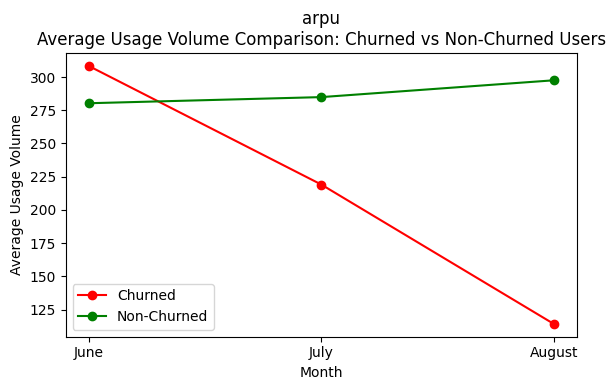

onnet_mou


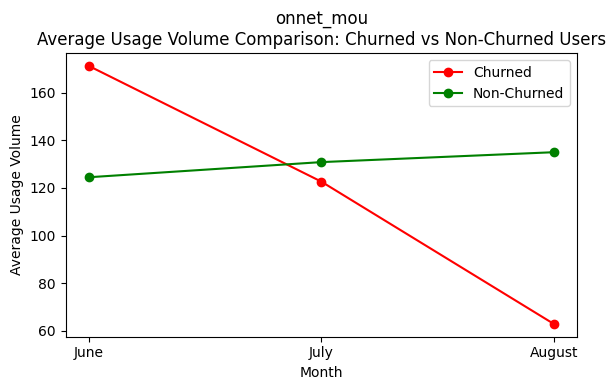

offnet_mou


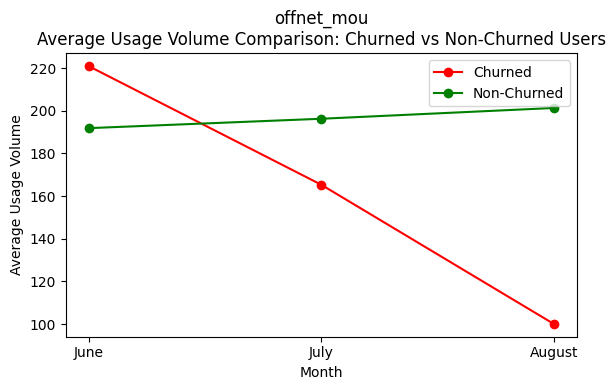

roam_ic_mou


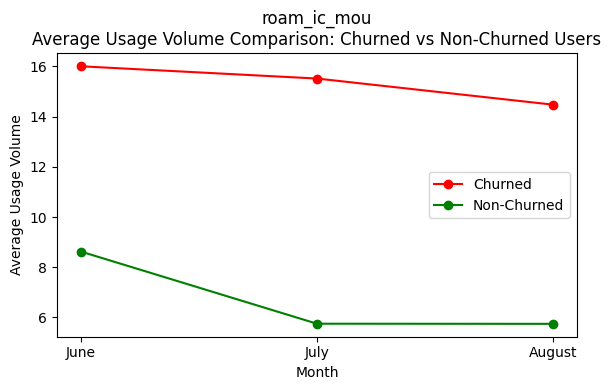

roam_og_mou


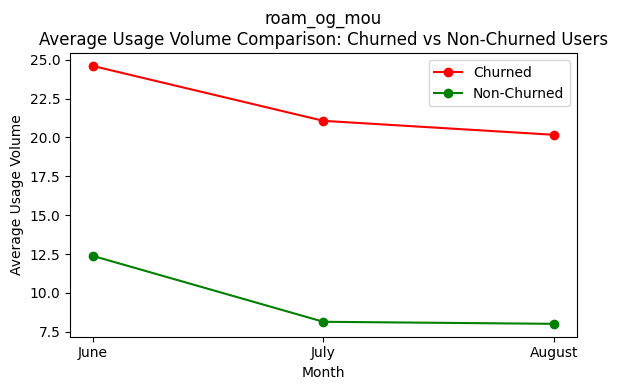

loc_og_t2t_mou


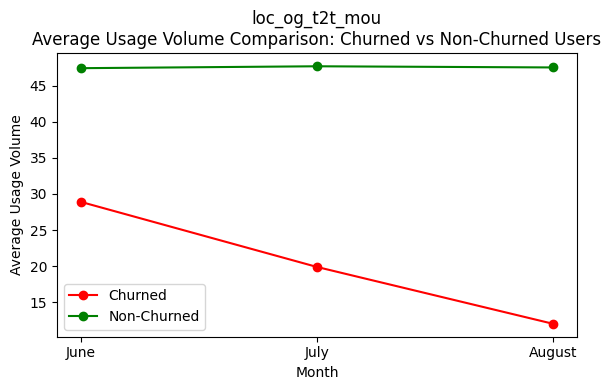

loc_og_t2m_mou


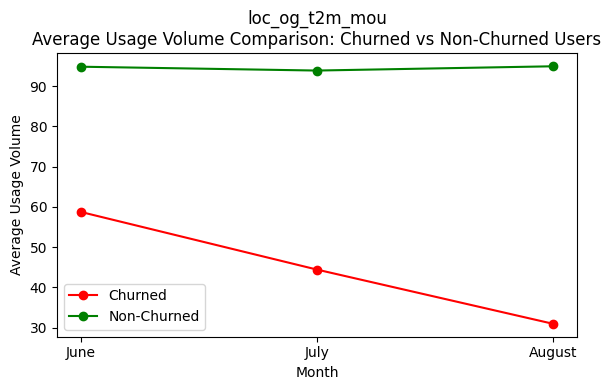

loc_og_t2f_mou


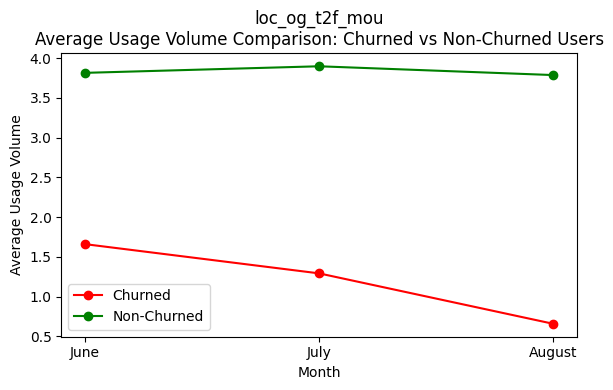

loc_og_t2c_mou


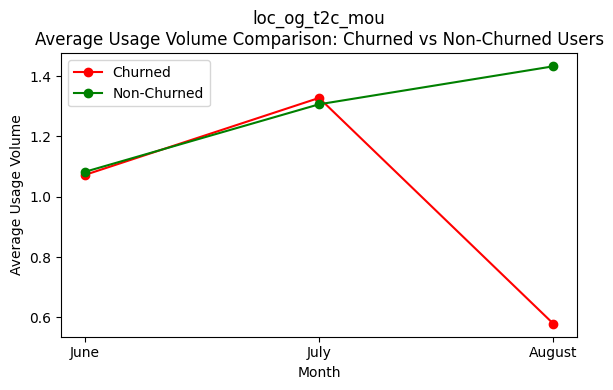

loc_og_mou


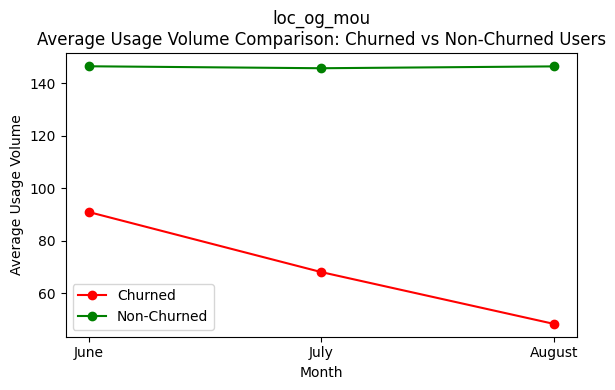

std_og_t2t_mou


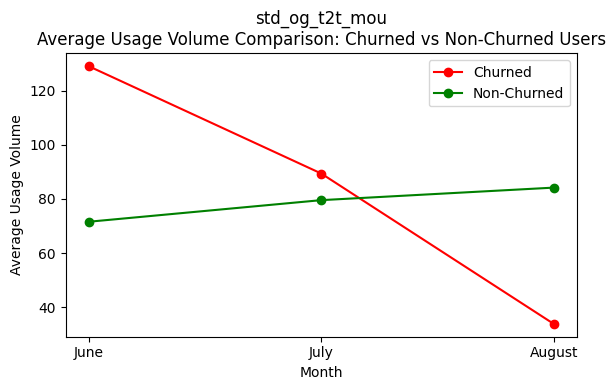

std_og_t2m_mou


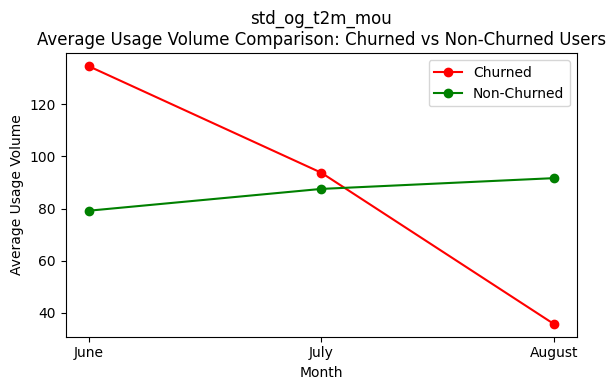

std_og_t2f_mou


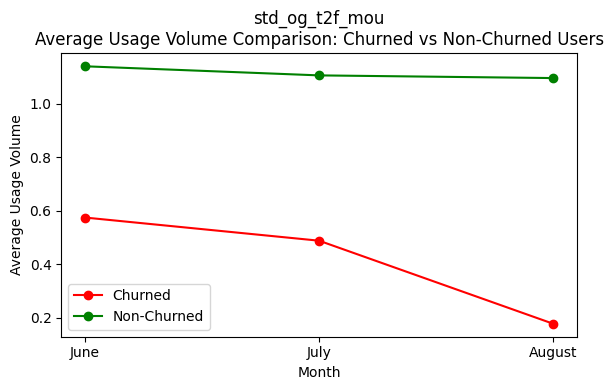

std_og_mou


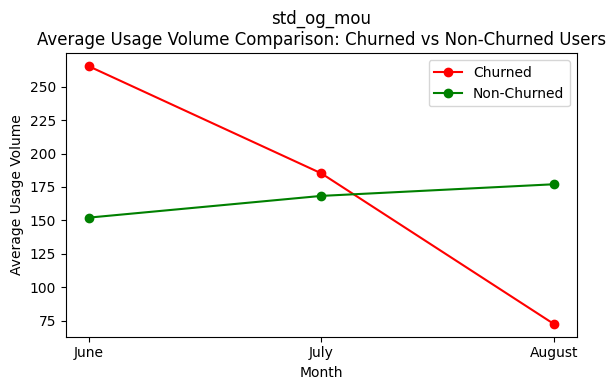

isd_og_mou


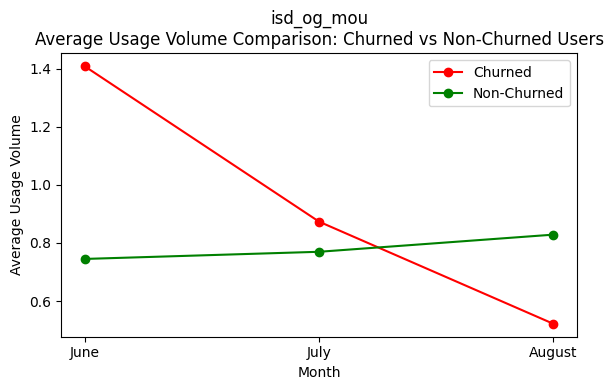

spl_og_mou


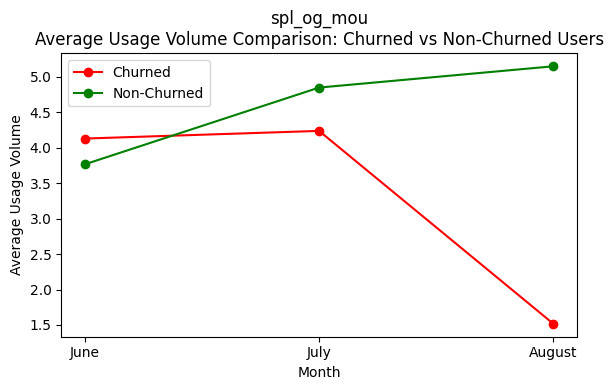

og_others


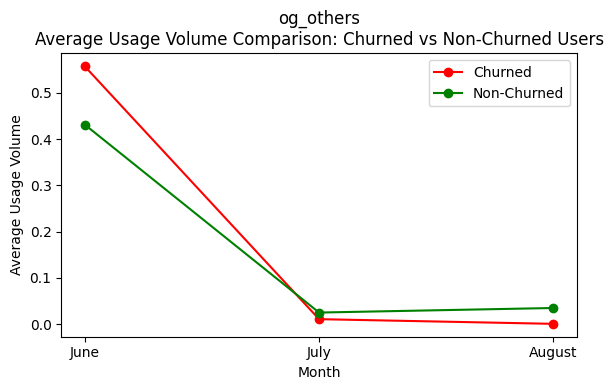

total_og_mou


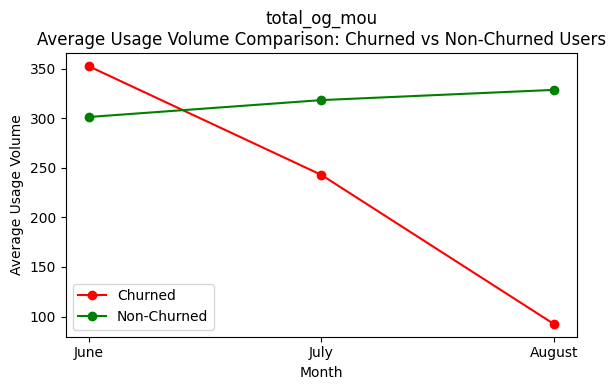

loc_ic_t2t_mou


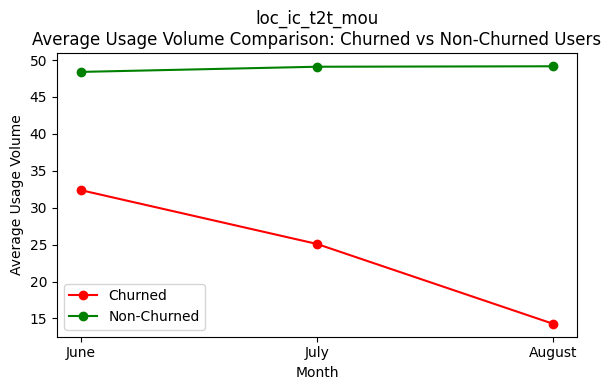

loc_ic_t2m_mou


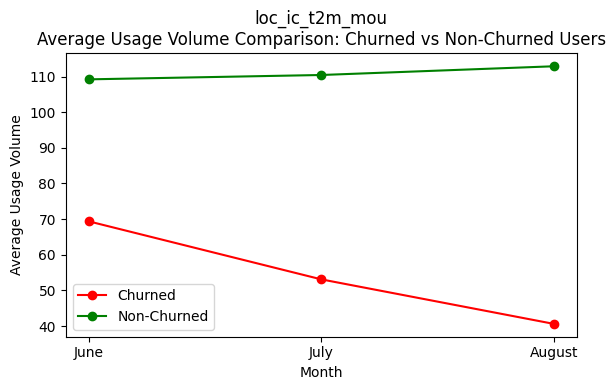

loc_ic_t2f_mou


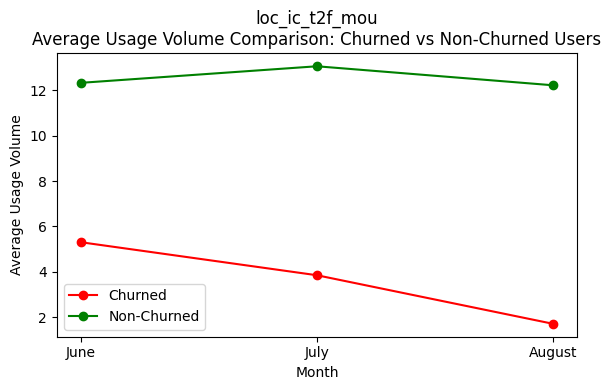

loc_ic_mou


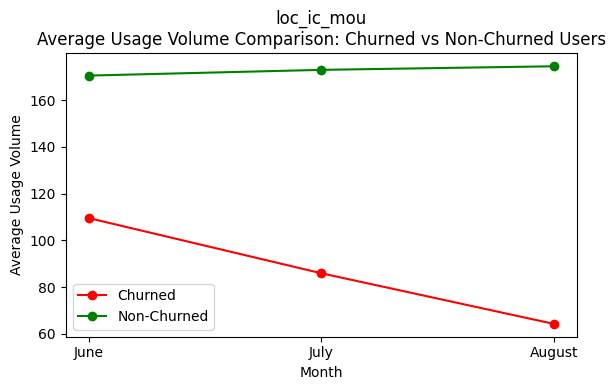

std_ic_t2t_mou


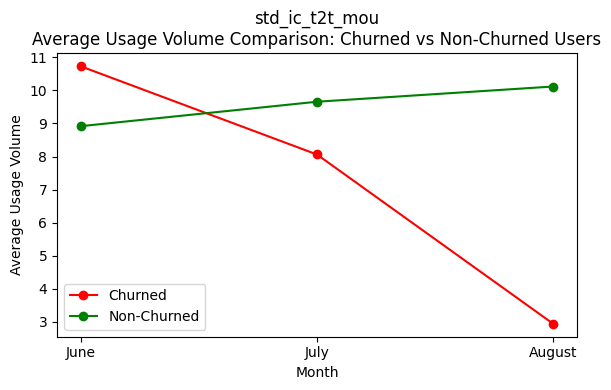

std_ic_t2m_mou


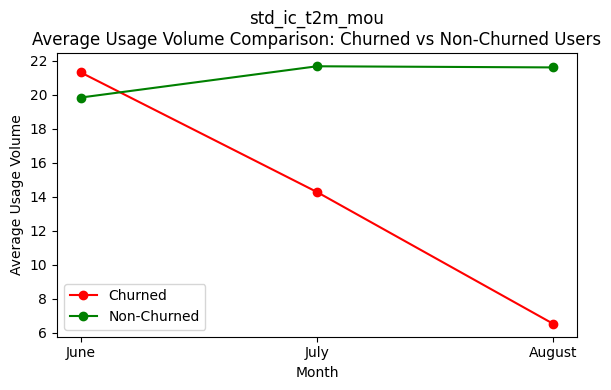

std_ic_t2f_mou


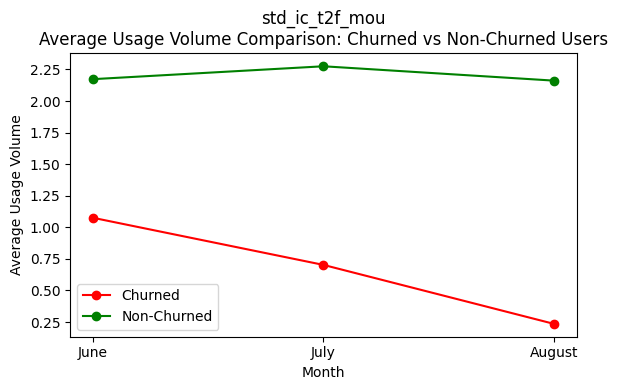

std_ic_mou


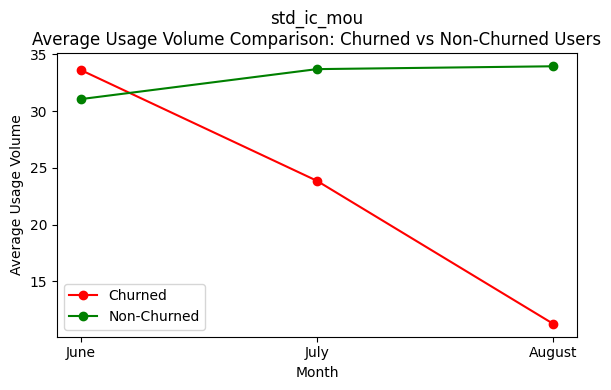

total_ic_mou


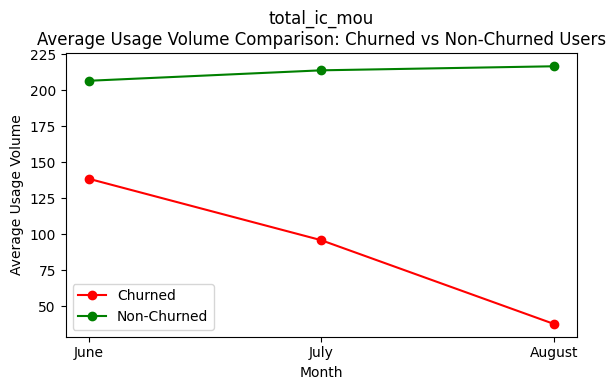

spl_ic_mou


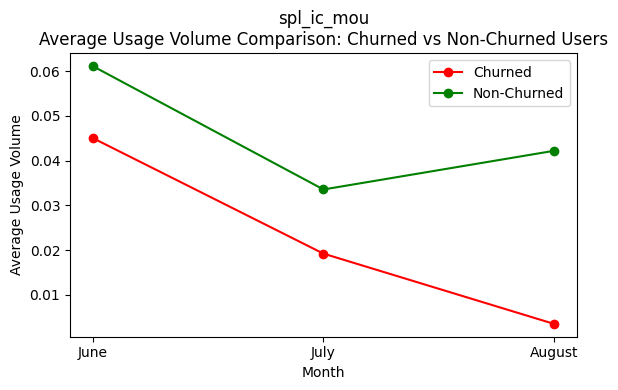

isd_ic_mou


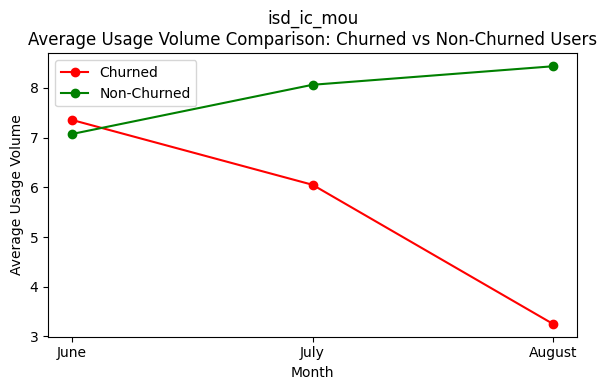

ic_others


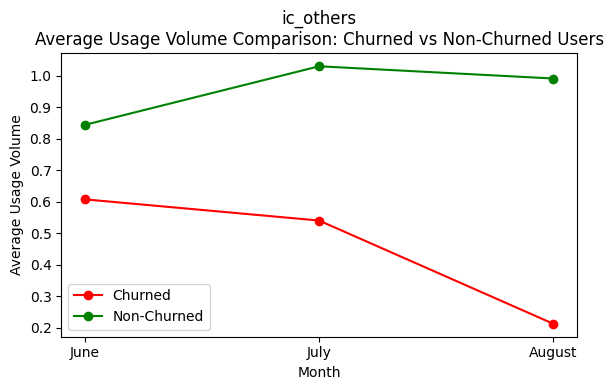

total_rech_num


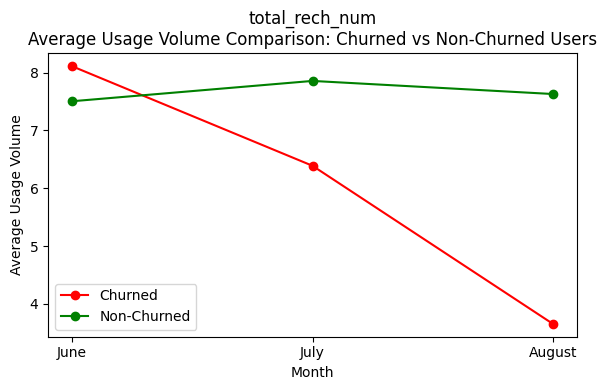

total_rech_amt


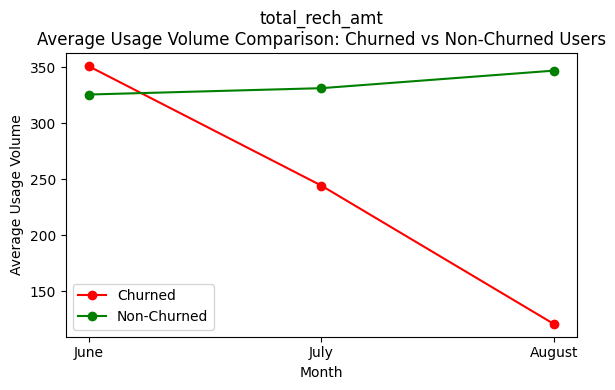

max_rech_amt


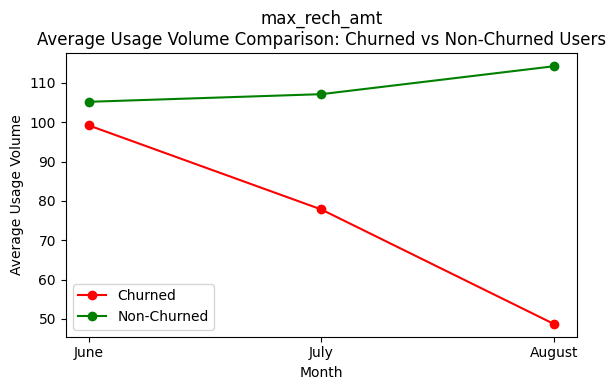

last_day_rch_amt


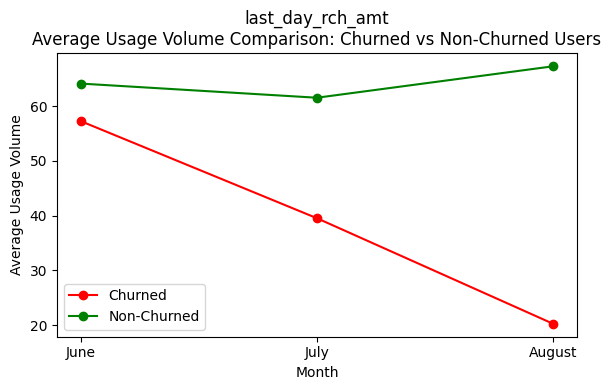

total_rech_data


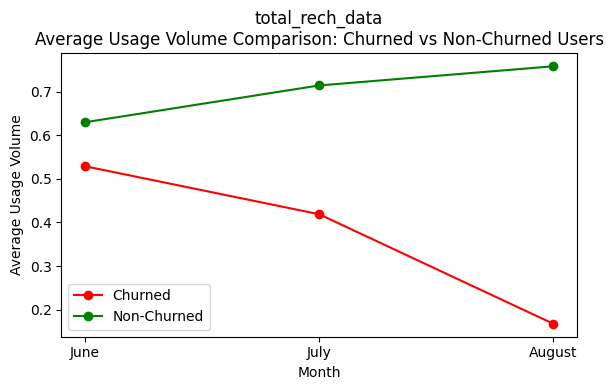

max_rech_data


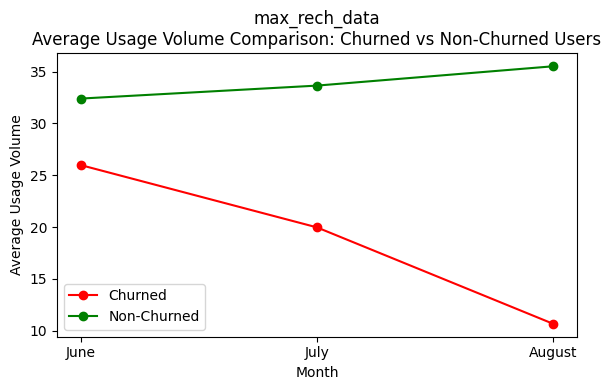

count_rech_2g


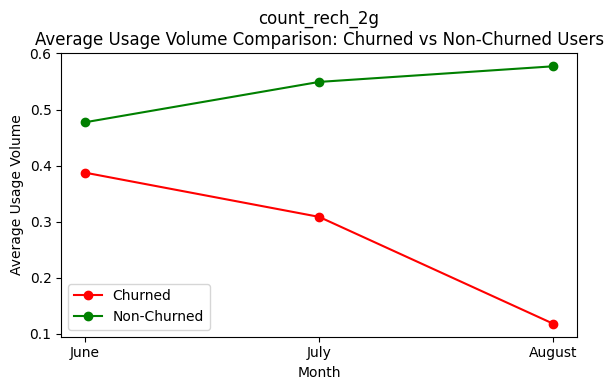

count_rech_3g


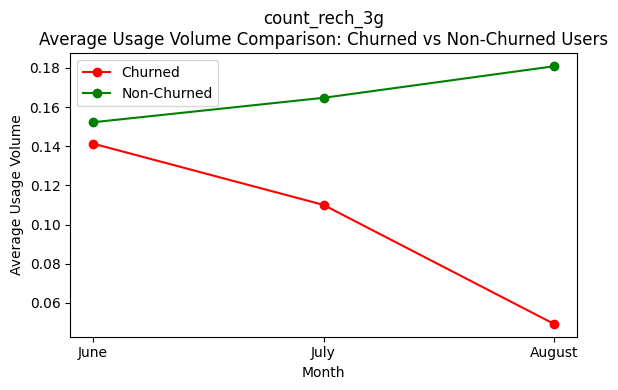

av_rech_amt_data


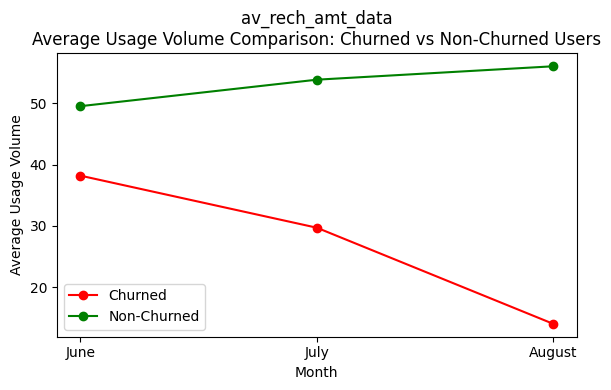

vol_2g_mb


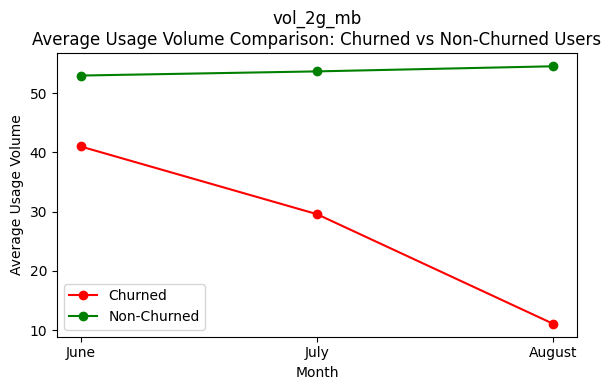

vol_3g_mb


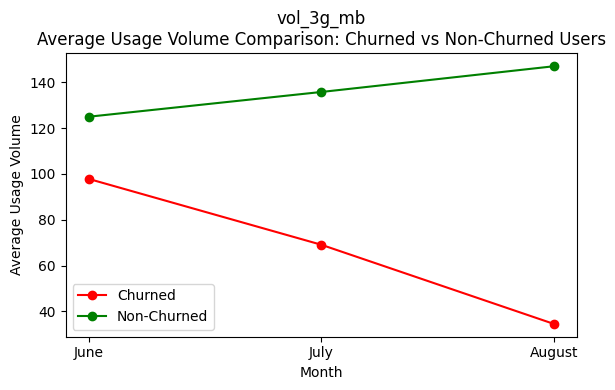

arpu_3g


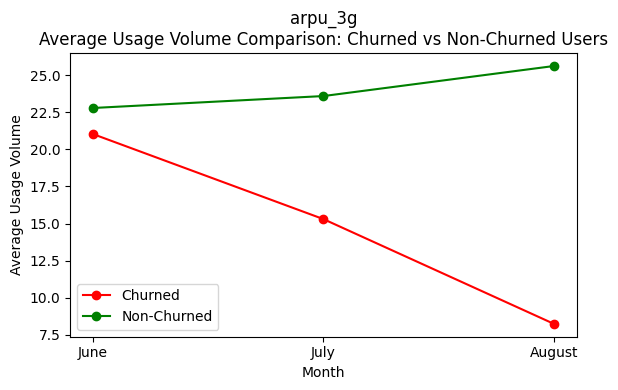

arpu_2g


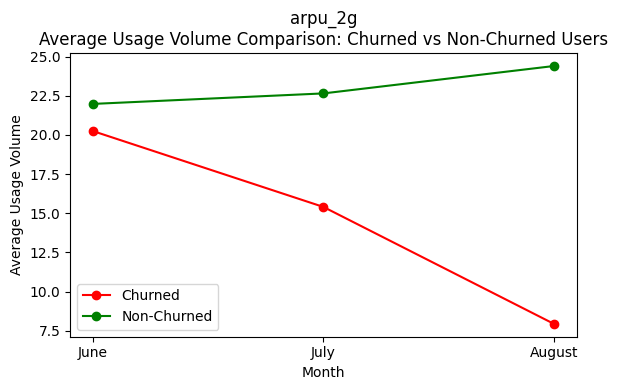

monthly_2g


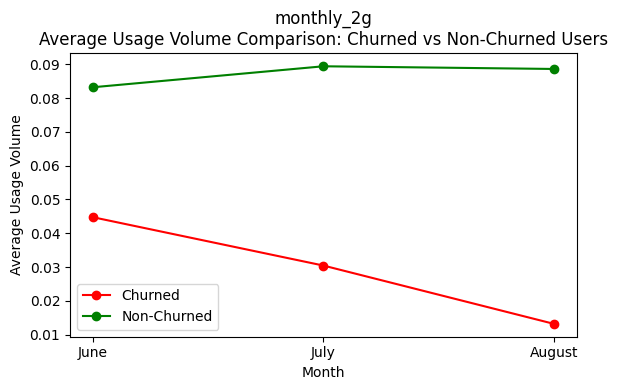

sachet_2g


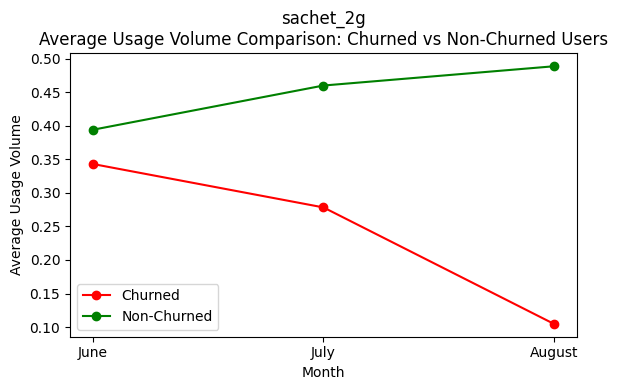

monthly_3g


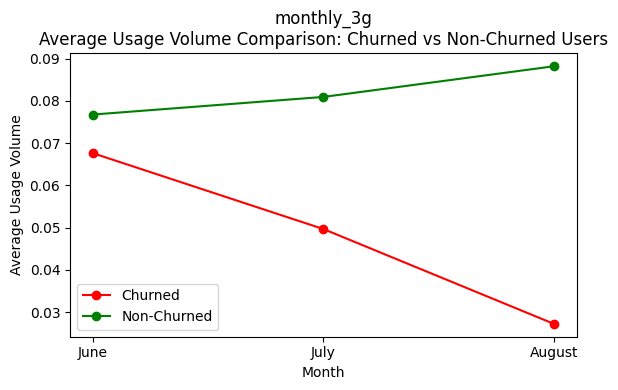

sachet_3g


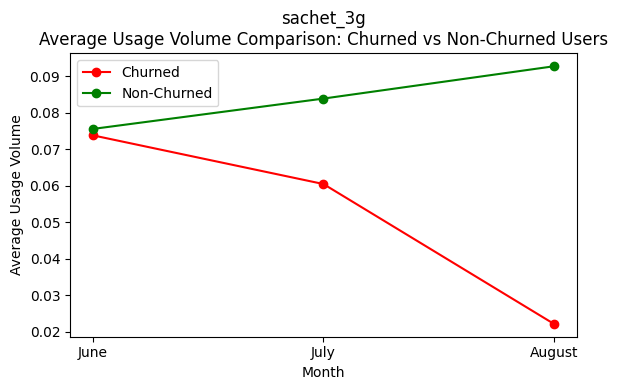

In [187]:
for c in column_groups:
    #---------------------------------------------
    # Plotting
    #--------------- ------------------------------
    print (f'{c[0][:-2]}')
    plot_usage_volume(
        data=data,
        col_june=c[0],
        col_july=c[1],
        col_aug=c[2]
    )

## Outliers

In [188]:
def outlier_handling(dataframe):
    """
    Applies outlier handling transformations to the values in the given DataFrame.

    Parameters:
    - dataframe (DataFrame): The DataFrame containing the values to be transformed.

    Returns:
    - transformed_values (list): A list containing the transformed values based on the specified conditions.
    """

    transformed_values = []
    for value in dataframe:
        if value <= 0:
            transformed_values.append(float(0))
        elif float(value) == float(1.0):
            transformed_values.append(float(1.5))
        else:
            transformed_values.append(float(np.log1p(value)))

    return transformed_values

In [189]:
data.describe(percentiles=[.25, .50, .75, .90, .95, .99]).T

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
id,69999.0,34999.000000,20207.115084,0.000,17499.500,34999.000,52498.5000,62998.2000,66498.1000,69298.02000,69998.000
arpu_6,69999.0,283.134365,334.213918,-2258.709,93.581,197.484,370.7910,619.9938,832.0227,1400.27664,27731.088
arpu_7,69999.0,278.185912,344.366927,-1289.715,86.714,191.588,365.3695,615.6614,823.2367,1414.89138,35145.834
arpu_8,69999.0,278.858826,351.924315,-945.808,84.095,192.234,369.9090,614.9946,828.4647,1445.05480,33543.624
onnet_mou_6,69999.0,129.236765,294.605405,0.000,8.060,34.110,113.1000,331.7660,598.6000,1429.04040,7376.710
onnet_mou_7,69999.0,129.993840,305.867956,0.000,7.260,32.280,108.9400,334.8860,608.8780,1461.34220,8157.780
onnet_mou_8,69999.0,127.641721,304.373330,0.000,7.360,32.100,106.2800,326.2980,596.1250,1448.89100,10752.560
offnet_mou_6,69999.0,194.825731,311.131642,0.000,36.880,96.480,223.5400,468.8980,719.5000,1520.31000,8362.360
offnet_mou_7,69999.0,193.112523,316.878225,0.000,33.980,91.885,218.3500,470.0540,731.6020,1517.83860,7043.980
offnet_mou_8,69999.0,191.002562,316.270571,0.000,34.390,91.800,216.4100,467.6360,715.9150,1492.23240,14007.340


In [190]:
numerical_columns = list(data.select_dtypes(include=['number']))
numerical_columns.remove('id')
numerical_columns

['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t

In [191]:
data[numerical_columns] = data[numerical_columns].apply(outlier_handling)
unseen[numerical_columns] = unseen[numerical_columns].apply(outlier_handling)

In [192]:
data.shape, unseen.shape

((69999, 153), (30000, 152))

# High Value customers

- We will use total recharge amount to determine high value customer
- Arpu has negative values making it difficult candidate for the task
- We have total_rech_amt_* to get calling recharge but no equivalent for data recharge
- We will use av_rech_amt_data_* and total_rech_data_* to get to total_rech_data_amt_*


In [193]:
cut_off = 0.7

In [194]:
# Calculating total data recharge amounts for months 6, 7, and 8
total_rech_data_amt = pd.DataFrame({
    'total_rech_data_amt_6': data['total_rech_data_6'] * data['av_rech_amt_data_6'],
    'total_rech_data_amt_7': data['total_rech_data_7'] * data['av_rech_amt_data_7'],
    'total_rech_data_amt_8': data['total_rech_data_8'] * data['av_rech_amt_data_8']
})

# Concatenating new columns to the existing DataFrame
data = pd.concat([data, total_rech_data_amt], axis=1)

# Adding total recharge amounts (regular and data recharges) for months 6, 7, and 8
data['total_amt_6'] = data['total_rech_amt_6'] + data['total_rech_data_amt_6']
data['total_amt_7'] = data['total_rech_amt_7'] + data['total_rech_data_amt_7']
data['total_amt_8'] = data['total_rech_amt_8'] + data['total_rech_data_amt_8']

# Calculating the 75th percentile for each month's total recharge amount
percentiles = data[['total_amt_6', 'total_amt_7', 'total_amt_8']].quantile(cut_off)

# Defining high-value customers based on the 75th percentile
data['high_value_customer'] = (
    (data['total_amt_6'] > percentiles['total_amt_6']) |
    (data['total_amt_7'] > percentiles['total_amt_7']) |
    (data['total_amt_8'] > percentiles['total_amt_8'])
)

In [195]:
data[['id', 'high_value_customer']].head()

,id,high_value_customer
0,0,False
1,1,True
2,2,False
3,3,False
4,4,True


In [196]:
# Calculating total data recharge amounts for months 6, 7, and 8
total_rech_data_amt = pd.DataFrame({
    'total_rech_data_amt_6': unseen['total_rech_data_6'] * unseen['av_rech_amt_data_6'],
    'total_rech_data_amt_7': unseen['total_rech_data_7'] * unseen['av_rech_amt_data_7'],
    'total_rech_data_amt_8': unseen['total_rech_data_8'] * unseen['av_rech_amt_data_8']
})

# Concatenating new columns to the existing DataFrame
unseen = pd.concat([unseen, total_rech_data_amt], axis=1)

# Adding total recharge amounts (regular and data recharges) for months 6, 7, and 8
unseen['total_amt_6'] = unseen['total_rech_amt_6'] + unseen['total_rech_data_amt_6']
unseen['total_amt_7'] = unseen['total_rech_amt_7'] + unseen['total_rech_data_amt_7']
unseen['total_amt_8'] = unseen['total_rech_amt_8'] + unseen['total_rech_data_amt_8']

# Calculating the 75th percentile for each month's total recharge amount
# Using same percentile as train data

# Defining high-value customers based on the 75th percentile
unseen['high_value_customer'] = (
    (unseen['total_amt_6'] > percentiles['total_amt_6']) |
    (unseen['total_amt_7'] > percentiles['total_amt_7']) |
    (unseen['total_amt_8'] > percentiles['total_amt_8'])
)

In [197]:
unseen[['id', 'high_value_customer']].head()

,id,high_value_customer
0,69999,False
1,70000,False
2,70001,True
3,70002,False
4,70003,False


In [198]:
data['high_value_customer'].value_counts()/ len(data) *100

high_value_customer
False    56.243661
True     43.756339
Name: count, dtype: float64

In [199]:
unseen['high_value_customer'].value_counts()/ len(unseen) *100

high_value_customer
False    56.073333
True     43.926667
Name: count, dtype: float64

In [200]:
data['high_value_customer'] = data['high_value_customer'].astype(int).astype('category')
unseen['high_value_customer'] = unseen['high_value_customer'].astype(int).astype('category')

In [201]:
data_copy = data.copy(deep=True)
# data = data[data['high_value_customer'] == 1]

In [202]:
data.shape, unseen.shape

((69999, 160), (30000, 159))

# Feature Egineering

Confused about slope -- why it does improve perfomance of prediction and rather decreased accuracy.

## Slope

We have seen decresing trend across months for churn users v/s increasing or stable trend for non-churn users.
We will capture this trend as slope for each monthly KPI

Though trend is not significant for few KPI, we will calculate slope for all variables and tackle extra variable during feature selection. 

In [203]:
# def change_in_usages(data: pd.DataFrame, col_june: str, col_july: str, col_aug: str) -> Tuple[pd.Series, str]:
#     """
#     Calculate the rolling slope of usage volume between June, July, and August to capture trends.

#     Parameters:
#     data (pd.DataFrame): The DataFrame containing the usage data.
#     col_june (str): The column name for June data.
#     col_july (str): The column name for July data.
#     col_aug (str): The column name for August data.

#     Returns:
#     pd.Series with slope
#     """
#     # Create a DataFrame containing the usage columns for June, July, and August
#     usage_df = data[[col_june, col_july, col_aug]]
    
#     base_name = f'Slope_{col_june[:-2]}'

#     # Calculate the slope using numpy's polyfit function (degree 1 for linear fit)
#     slope = usage_df.apply(lambda row: np.polyfit([1, 2, 3], row, 1)[0], axis=1)
#     # print (base_name, flush=True)
#     return slope, base_name

# Improved slope calculation using numpy instead of Pandas apply.
def change_in_usages(data: pd.DataFrame, col_june: str, col_july: str, col_aug: str) -> Tuple[pd.Series, str]:
    """
    Calculate the rolling slope of usage volume between June, July, and August to capture trends.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the usage data.
    col_june (str): The column name for June data.
    col_july (str): The column name for July data.
    col_aug (str): The column name for August data.

    Returns:
    pd.Series with slope
    """
    # Create a DataFrame containing the usage columns for June, July, and August
    usage_df = data[[col_june, col_july, col_aug]].to_numpy()

    base_name = f'Slope_{col_june[:-2]}'

    # Predefine X values for the three months: June (1), July (2), August (3)
    X = np.array([1, 2, 3])

    # Use numpy for vectorized linear regression: (XTX)^-1 XTy gives slope for each row
    X_mean = X.mean()
    X_centered = X - X_mean
    denominator = np.sum(X_centered ** 2)

    # Calculate slopes using vectorized dot products
    y_mean = np.mean(usage_df, axis=1)
    slope = np.dot(usage_df - y_mean[:, None], X_centered) / denominator

    return pd.Series(slope), base_name

In [204]:
%%time

temp_data_main = pd.DataFrame() # Empty data to hold new slope variables.
columns_to_drop_main = []
for c in column_groups:
    # Calculate slop
    # slope, col_name = change_in_usages(
    slope, col_name = change_in_usages_v2(
        data=data,
        col_june=c[0],
        col_july=c[1],
        col_aug=c[2]
    )
    temp_data_main[col_name] = slope
    columns_to_drop_main.append(c[0])
    columns_to_drop_main.append(c[1])
    columns_to_drop_main.append(c[2])

data = data.drop(columns=columns_to_drop_main)
data = pd.concat([data, temp_data_main], axis=1)

C:\Users\amit.mohite\AppData\Local\Temp\ipykernel_14776\2304258640.py:88: RuntimeWarning: divide by zero encountered in divide
  pct_change = ((usage_df[:, 2] - usage_df[:, 0]) / usage_df[:, 0]) * 100
C:\Users\amit.mohite\AppData\Local\Temp\ipykernel_14776\2304258640.py:88: RuntimeWarning: invalid value encountered in divide
  pct_change = ((usage_df[:, 2] - usage_df[:, 0]) / usage_df[:, 0]) * 100


ValueError: too many values to unpack (expected 2)

In [205]:
%%time

temp_data_unseen = pd.DataFrame() # Empty dataframe 
columns_to_drop_unseen = []
for c in column_groups:
    # Calculate slop for unseen 
    # slope, col_name = change_in_usages(
    slope, col_name = change_in_usages_v2(
        data=unseen,
        col_june=c[0],
        col_july=c[1],
        col_aug=c[2]
    )
    temp_data_unseen[col_name] = slope
    columns_to_drop_unseen.append(c[0])
    columns_to_drop_unseen.append(c[1])
    columns_to_drop_unseen.append(c[2])

unseen = unseen.drop(columns=columns_to_drop_unseen)
unseen = pd.concat([unseen, temp_data_unseen], axis=1)

C:\Users\amit.mohite\AppData\Local\Temp\ipykernel_14776\2304258640.py:88: RuntimeWarning: divide by zero encountered in divide
  pct_change = ((usage_df[:, 2] - usage_df[:, 0]) / usage_df[:, 0]) * 100
C:\Users\amit.mohite\AppData\Local\Temp\ipykernel_14776\2304258640.py:88: RuntimeWarning: invalid value encountered in divide
  pct_change = ((usage_df[:, 2] - usage_df[:, 0]) / usage_df[:, 0]) * 100


ValueError: too many values to unpack (expected 2)

In [206]:
columns_to_drop_unseen == columns_to_drop_main

True

In [ ]:
data.shape, unseen.shape

## One-hot encoding 

In [ ]:
categorical_columns = list(data.select_dtypes(include=['category']).columns)
categorical_columns.remove('churn_probability') # Already in the right format.
categorical_columns

In [188]:
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True, dtype=float)
unseen = pd.get_dummies(unseen, columns=categorical_columns, drop_first=True, dtype=float)

In [ ]:
data.shape, unseen.shape

# Train - test split and SMOTE

In [ ]:
X = data.drop(columns=['churn_probability'])
y = data['churn_probability']

X.shape, y.shape

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

# Handling data imbalance using SMOTE

In [ ]:
y_train.value_counts() / len (y_train) * 100

We have imbalance in the data

In [193]:
# from imblearn.over_sampling import KMeansSMOTE
# kmeans_smote = KMeansSMOTE(sampling_strategy=0.5, random_state=42, kmeans_estimator=5, cluster_balance_threshold=0.1)
# X_resampled, y_resampled = kmeans_smote.fit_resample(X, y)

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
y_resampled.value_counts() / len (y_resampled) * 100

In [ ]:
X_resampled.shape, y_resampled.shape

In [196]:
# Handy function to write submisson file. 
def create_submission(id : pd.Series, prediction : pd.Series, model_name : str) -> None:
    submission = pd.DataFrame({'id': id.astype(int), 'churn_probability': prediction})
    submission.to_csv(f'submission_{model_name}.csv', index=False)

In [197]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_prob):
    """
    Plots the ROC curve for the given true labels and predicted probabilities.

    Parameters:
    y_true (array-like): True binary labels (0s and 1s).
    y_pred_prob (array-like): Predicted probabilities for the positive class (1).
    
    Returns:
    None
    """
    # Calculate the ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# PCA for Determining Critical Components


In [ ]:
# Standardize the data before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)  # Assuming X_resampled is the feature data

# Apply PCA without specifying n_components to capture all components
pca = PCA()
pca.fit(X_scaled)

# Get the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plot the explained variance to visualize how much variance each component explains
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Calculate the cumulative explained variance
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance to identify the number of components needed
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Find the number of components that explain at least 90% of the variance
n_components_90 = next(i for i, total_var in enumerate(cumulative_explained_variance) if total_var >= 0.90) + 1
n_components_95 = next(i for i, total_var in enumerate(cumulative_explained_variance) if total_var >= 0.95) + 1
n_components_99 = next(i for i, total_var in enumerate(cumulative_explained_variance) if total_var >= 0.99) + 1
print(f'Number of components explaining at least 90% of the variance: {n_components_90}')
print(f'Number of components explaining at least 95% of the variance: {n_components_95}')
print(f'Number of components explaining at least 99% of the variance: {n_components_99}')


# Model 1 - Logistic Regression with RFE

In [ ]:
%%time

# Define the pipeline
logreg_rfe_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('rfe', RFE(estimator=LogisticRegression(random_state=42, max_iter=500))),
    ('logreg', LogisticRegression(random_state=42, max_iter=500))
])

# Define the hyperparameters for GridSearchCV
param_grid = {
    'rfe__n_features_to_select': [10, 15, 20, 25],            # Number of features to select in RFE
    'logreg__C': [0.001, 0.01, 0.1, 1, 10],                 # Regularization strength (C)
    'logreg__penalty': ['l1', 'l2'],                        # Penalty type (l1 for Lasso, l2 for Ridge)
    'logreg__solver': ['liblinear', 'saga']                   # Solvers that support l1 and l2 penalties
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=logreg_rfe_pipeline, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Train the grid search on the resampled data
grid_search.fit(X_resampled, y_resampled)

# Get the best estimator from grid search
best_pipeline = grid_search.best_estimator_

# Make predictions on the validation set
y_val_pred = best_pipeline.predict(X=X_val)

# Evaluate the model
print(classification_report(y_val, y_val_pred))

# Plot ROC curve
y_val_pred_prob = best_pipeline.predict_proba(X_val)
RocCurveDisplay.from_predictions(y_val, y_val_pred_prob[:, 1])
plt.show()

# Create Kaggle submission
y_unseen_pred = best_pipeline.predict(X=unseen)
create_submission(id=unseen['id'], prediction=y_unseen_pred, model_name='logreg_rfe_pipeline_with_grid_search')

# Model 2 - Logistic Regression with PCA, RFE and Hyperparameter Tuning 

In [ ]:
%%time
# Create a pipeline with StandardScaler, PCA, RFE, and LogisticRegression
logreg_pca_rfe_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=n_components_95)),
    ('rfe', RFE(estimator=LogisticRegression(random_state=42), n_features_to_select=20)),
    ('logreg', LogisticRegression(random_state=42))
])

from sklearn.model_selection import GridSearchCV

# Define a parameter grid for Logistic Regression
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10],       # Regularization strength
    'logreg__penalty': ['l1', 'l2'],              # Penalty type
    'pca__n_components': [30, 36],                # PCA component tuning
    'rfe__n_features_to_select': [10, 15, 20]     # RFE feature selection tuning
}

# Create the GridSearchCV object
grid_search = GridSearchCV(logreg_pca_rfe_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model using GridSearchCV
grid_search.fit(X_resampled, y_resampled)

# Evaluate the best model on the validation set
y_val_pred = grid_search.best_estimator_.predict(X_val)
print(classification_report(y_val, y_val_pred))

# Plot ROC curve for the best model
y_val_pred_prob = grid_search.best_estimator_.predict_proba(X_val)
plot_roc_curve(y_val, y_val_pred_prob[:, 1])

# Make predictions on the unseen data
y_unseen_pred = grid_search.best_estimator_.predict(unseen)
create_submission(id=unseen['id'], prediction=y_unseen_pred, model_name='logreg_pca_rfe_tuned')

# # Train the pipeline on the resampled data
# logreg_pca_rfe_pipeline.fit(X_resampled, y_resampled)

# # Make predictions on the validation set
# y_val_pred = logreg_pca_rfe_pipeline.predict(X_val)

# # Evaluate the model
# print(classification_report(y_val, y_val_pred))

# # Plot ROC curve
# y_val_pred_prob = logreg_pca_rfe_pipeline.predict_proba(X_val)
# plot_roc_curve(y_val, y_val_pred_prob[:, 1])

# # Create Kaggle submission
# y_unseen_pred = logreg_pca_rfe_pipeline.predict(X=unseen)
# create_submission(id=unseen['id'], prediction=y_unseen_pred, model_name='logreg_pca_rfe_pipeline')

# Model 3 - Decision Tree with PCA and GridSearchCV

In [ ]:
%%time
# Define the pipeline with StandardScaler, PCA, and DecisionTreeClassifier
dt_pca_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=n_components_95)),
    ('dt', DecisionTreeClassifier(random_state=42))  # Decision Tree classifier
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'dt__max_depth': [5, 10, 15, 20],               
    'dt__min_samples_leaf': [5, 10, 20, 50, 100],
    'dt__criterion': ['gini', 'entropy']            # Criterion for split
}

# Initialize GridSearchCV with DecisionTree and the parameter grid
grid_search = GridSearchCV(estimator=dt_pca_pipeline, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1)

# Fit the grid search on the resampled data
grid_search.fit(X_resampled, y_resampled)

# Make predictions on the validation set
y_val_pred = grid_search.predict(X_val)

# Plot ROC curve
y_val_pred_prob = grid_search.predict_proba(X_val)
plot_roc_curve(y_val, y_val_pred_prob[:, 1])

# Create Kaggle submission with predictions for unseen data
y_unseen_pred = grid_search.predict(X=unseen)
create_submission(id=unseen['id'], prediction=y_unseen_pred, model_name='dt_pca_pipeline')

# Model 4 - Random Forest with PCA and GridSearchCV

In [603]:
%%time
# Define the pipeline with StandardScaler, PCA, and RandomForestClassifier
rf_pca_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=n_components_95)),  
    ('rf', RandomForestClassifier(random_state=42)) 
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'rf__n_estimators': [100, 200, 300],        # Number of trees
    'rf__max_depth': [10, 20, 30],              # Max depth of the trees
    'rf__min_samples_split': [2, 5, 10],        # Minimum number of samples required to split
    'rf__min_samples_leaf': [1, 2, 4],          # Minimum number of samples at leaf node
    'rf__criterion': ['gini', 'entropy']        # Criterion for split
}

# Initialize GridSearchCV with RandomForestClassifier and the parameter grid
grid_search_rf = GridSearchCV(estimator=rf_pca_pipeline, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1)

# Fit the grid search on the resampled data
grid_search_rf.fit(X_resampled, y_resampled)

# Make predictions on the validation set
y_val_pred = grid_search_rf.predict(X_val)

# Plot ROC curve
y_val_pred_prob = grid_search_rf.predict_proba(X_val)
plot_roc_curve(y_val, y_val_pred_prob[:, 1])

# Create Kaggle submission with predictions for unseen data
y_unseen_pred = grid_search_rf.predict(X=unseen)
create_submission(id=unseen['id'], prediction=y_unseen_pred, model_name='rf_pca_pipeline')

# Model 5 - XGBoost with PCA and GridSearchCV

In [ ]:
%%time
# Define the pipeline with StandardScaler, PCA, and XGBClassifier
xgb_pca_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=n_components_95)),
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))  # XGBoost classifier
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'xgb__n_estimators': [100, 200, 300],          # Number of boosting rounds
    'xgb__max_depth': [3, 5, 7],                   # Maximum depth of a tree
    'xgb__learning_rate': [0.01, 0.1, 0.2],        # Step size shrinkage
    'xgb__subsample': [0.7, 0.8, 1.0],             # Subsample ratio of the training instances
    'xgb__colsample_bytree': [0.7, 0.8, 1.0],      # Subsample ratio of columns when constructing each tree
    'xgb__min_child_weight': [1, 3, 5]             # Minimum sum of instance weight needed in a child
}

# Initialize GridSearchCV with XGBClassifier and the parameter grid
grid_search_xgb = GridSearchCV(estimator=xgb_pca_pipeline, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1)

# Fit the grid search on the resampled data
grid_search_xgb.fit(X_resampled, y_resampled)

# Make predictions on the validation set
y_val_pred = grid_search_xgb.predict(X_val)

# Evaluate the model using classification report and precision score
print(classification_report(y_val, y_val_pred))

# Plot ROC curve
y_val_pred_prob = grid_search_xgb.predict_proba(X_val)
plot_roc_curve(y_val, y_val_pred_prob[:, 1])

# Create Kaggle submission with predictions for unseen data
y_unseen_pred = grid_search_xgb.predict(X=unseen)
create_submission(id=unseen['id'], prediction=y_unseen_pred, model_name='xgb_pca_pipeline')